In [1]:
import pandas as pd
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE as TSNE
from torch.nn import Linear, LeakyReLU, SiLU
from scipy import spatial
from sklearn.metrics import roc_auc_score

from sklearn.metrics import average_precision_score
import time
import torch_geometric.transforms as T
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# loss plot
def loss_plot(epoch,loss_list):
    #fig = plt.figure(1)	#identifies the figure 
    plt.plot([i for i in range(epoch)], loss_list)
    plt.xlabel("epoch",fontsize='13')
    plt.ylabel("loss",fontsize='13')
    plt.grid()
    plt.savefig(f'loss.png')
    #plt.clf()

def train_edge(train):
    
    X_train = np.array(train[['from','to',]])
    y_train = np.array(train['label'])
    edge_index = torch.tensor(X_train.T, dtype=torch.long)
    pos_edge_index = torch.tensor(X_train[y_train== 1].T, dtype=torch.long)
    pos_edge_label = torch.tensor(y_train[y_train== 1], dtype=torch.float)
    return edge_index, pos_edge_index, pos_edge_label

def test_edge(test):
    
    X_test = np.array(test[['from','to',]])
    edge_index = torch.tensor(X_test.T, dtype=torch.long)
    return edge_index
    
    
def read_data(folder):
    train = pd.read_csv(f"hw2_data/{folder}/train.csv")
    test = pd.read_csv(f"hw2_data/{folder}/test.csv")
    content = pd.read_csv(f"hw2_data/{folder}/content.csv", sep="\t", header=None)
    return train, test, content 

In [3]:
class GCN(torch.nn.Module):

    def __init__(self,D_in, H, D_out):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.GCN1 = GCNConv(D_in, H)
        self.GCN2 = GCNConv(H, H)
        self.leakyrelu = LeakyReLU(0.2)

    def encoder(self,X,edge_index):
        X = self.GCN1(X, edge_index)
        X = self.leakyrelu(X)
        X = self.GCN2(X, edge_index)
        return  X
    
    def decoder(self,z,edge_label_index):
        logits = (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(axis=-1)
        return logits

# Data Transform 

In [5]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.1, num_test=0.1,is_undirected=True,
                       add_negative_train_samples=False),
])
dataset = 'dataset3'
X1_train, X1_test, X1_content = read_data(dataset)
X1_content = np.array(X1_content.set_index(0).sort_index())
X1_content = torch.tensor(X1_content, dtype=torch.float)

train_edge_index, train_pos_edge_index, train_pos_edge_label = train_edge(X1_train)
test_edge_index = test_edge(X1_test)

dataset =  Data(x = X1_content, num_features = X1_content.shape[1], 
                num_nodes = X1_content.shape[0],edge_index = train_edge_index,)               

train_data, val_data, test_data = transform(dataset)

train_data.edge_label = train_pos_edge_label
train_data.edge_label_index = train_pos_edge_index
train_data.to(device)

# train_data, val_data, test_data =  torch.load('train_data3.pt'), torch.load('val_data3.pt'), torch.load('test_data3.pt')
train_data, val_data, test_data

(Data(x=[877, 1703], edge_index=[2, 2050], num_features=1703, num_nodes=877, edge_label=[1273], edge_label_index=[2, 1273]),
 Data(x=[877, 1703], edge_index=[2, 2050], num_features=1703, num_nodes=877, edge_label=[256], edge_label_index=[2, 256]),
 Data(x=[877, 1703], edge_index=[2, 2306], num_features=1703, num_nodes=877, edge_label=[256], edge_label_index=[2, 256]))

# Train

In [36]:

model = GCN(train_data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

In [22]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encoder(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index],dim=-1,)
    
    edge_label = torch.cat([train_data.edge_label,train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    
    out = model.decoder(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label.float())
    auc = roc_auc_score(edge_label.cpu().detach().numpy(), out.cpu().detach().numpy())
    loss.backward()
    optimizer.step()
    return loss,auc


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encoder(data.x, data.edge_index)
    
    out = model.decoder(z, data.edge_label_index).view(-1).sigmoid()
    return out, roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [37]:

best_val_auc = best_test_auc = 0

best_val_epoch = best_test_epoch = 0
loss_list = []
train_list = []
val_list = []
test_list = []
for epoch in range(4000):
    
    loss,train_auc = train()
    out,val_auc = test(val_data)
    out,test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_val_epoch = epoch
        best_model = model
    if test_auc > best_test_auc:
        best_test_auc = test_auc
        best_test_epoch = epoch
        best_test_model = model
    
    if epoch % 500 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}',
          f'Test: {test_auc:.4f}')
            time.sleep(0.3)
 
    val_list.append(val_auc)
    train_list.append(train_auc)
    test_list.append(test_auc)
    loss_list.append(loss.item())
    

print(f'Final val epoch:{best_val_epoch:03d} auc:{best_val_auc:.4f},')
print(f'Final test epoch:{best_test_epoch:03d} auc:{best_test_auc:.4f},')

Epoch: 000, Loss: 0.6931, Val: 0.5489 Test: 0.5880
Epoch: 500, Loss: 0.5648, Val: 0.6306 Test: 0.6198
Epoch: 1000, Loss: 0.4994, Val: 0.6681 Test: 0.6816
Epoch: 1500, Loss: 0.4716, Val: 0.6874 Test: 0.6974
Epoch: 2000, Loss: 0.4620, Val: 0.7039 Test: 0.7203
Epoch: 2500, Loss: 0.4549, Val: 0.7078 Test: 0.7224
Epoch: 3000, Loss: 0.4427, Val: 0.7078 Test: 0.7206
Epoch: 3500, Loss: 0.4458, Val: 0.7382 Test: 0.6978
Final val epoch:3616 auc:0.7435,
Final test epoch:2238 auc:0.7286,


# test data to upload

In [16]:
ttt_data =  Data(x = train_data.x, num_features = X1_content.shape[1], num_nodes = X1_content.shape[0],
                  edge_index = test_data.edge_index, edge_label_index = test_edge_index)
ttt_data.to(device)
z = best_test_model.encoder(ttt_data.x, ttt_data.edge_index)
out = best_test_model.decoder(z, ttt_data.edge_label_index).view(-1).sigmoid()
i = 3
upload = pd.read_csv(f"hw2_data/dataset{i}/upload.csv")
upload['prob'] = out.cpu().detach().numpy()
upload.to_csv(f"hw2_data/dataset{i}/upload{i}.csv",index=False)

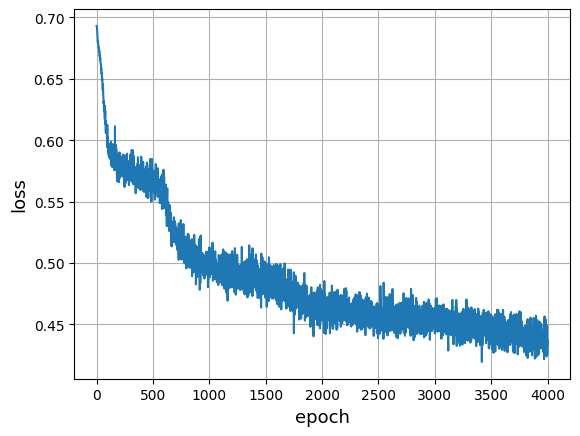

In [39]:
loss_plot(4000,loss_list)

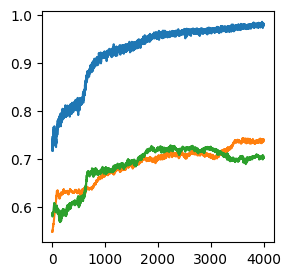

In [40]:
plt.figure(figsize=(3,3))
plt.plot([i for i in range(4000)],train_list)
plt.plot([i for i in range(4000)],val_list)
plt.plot([i for i in range(4000)],test_list)
plt.savefig(f'AUC.png')